# Irish POSTagger

To train a Galician POS tagger, we will use the [Irish UD treebank](https://github.com/UniversalDependencies/UD_Irish-IDT) dataset. This dataset is a part of the Universal Dependencies project and contains 4,910 sentences and 115,990 words.

The first 2924 sentences of which were taken from the New Corpus of Ireland-Irish (NCII), with text from books, newswire, websites and other media. These sentences are a subset of a gold-standard POS-tagged corpus for Irish made available by Elaine Uí Dhonnchadha of Trinity College Dublin.

The subsequent 1986 sentences were taken from a corpus of Irish public administration translations and are available under the Open Data (PSI) directive for sharing of pubic data:

- Citizens information website: 20%
- Dublin City Council (DCC): 25%
- Department of Culture, Heritage and the Gaeltacht (DCHG): 9%
- Udaras na Gaeltachta: 25%
- EUbookshop: 21%

There are other two datasets for Isish language in the Universal Dependencies project, but they are smaller than the Irish IDT dataset. So, similarily to the Galician language, we choose this dataset because it is the largest one.


In [3]:
from tagger import MyTagger
from utils import *

## Preprocessing

Similarily to as we did with English, we are going to preprocess the Irish UD treebank dataset. We are interested in the lenght of the sentences and in the number of distinct words in the dataset. With this information, we can adjust the padding added to all sentences and the size of the vocabulary.


In [5]:
irish_tagger = MyTagger(
    train_filename="data/irish/IDT/ga_idt-ud-train.conllu",
    val_filename="data/irish/IDT/ga_idt-ud-dev.conllu",
    test_filename="data/irish/IDT/ga_idt-ud-test.conllu",
)

In [6]:
train_sentences, train_words, val_sentences, val_words, test_sentences, test_words = calculate_statistics_tagger_data(
    irish_tagger
)

print(f"Training dataset - sentences: {train_sentences}, words: {train_words}")
print(f"Validation dataset - sentences: {val_sentences}, words: {val_words}")
print(f"Test dataset - sentences: {test_sentences}, words: {test_words}")

Training dataset - sentences: 4005, words: 95881
Validation dataset - sentences: 451, words: 10000
Test dataset - sentences: 454, words: 10109


Similarly to our approach with Galician and English, we will limit the maximum sequence length. Initially, we'll set this maximum to 100 and examine how many sentences exceed this limit, as well as identify the longest sentence in the dataset.

We found that the longest sentence in the dataset has 311 words, a lot of them. However, we do not find a lot of sentences with more than 100 words (only 9, which represents the 0.22% of the total number of sentences in the training dataset). So, we are going to set the maximum sequence length to 100.


In [9]:
max_sentence_num_words = 100
mean_len, std_len, max_len, sentences_over_max_length = calculate_statistics_dataset(
    irish_tagger.X_train, max_sentence_num_words=max_sentence_num_words
)

print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")
print(f"Max sentence length: {round(max_len, 2)}")

print(f"Number of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length)}")
print(
    f"Percentage of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length) / len(irish_tagger.X_train) * 100:.2f}%\n"
)
for i, sentence in enumerate(sentences_over_max_length):
    print(
        f'Sentence {i} has more than {max_sentence_num_words} words ({len(sentence.split())}). Sentence: "{sentence}"'
    )

Mean sentence length: 23.94
Standard deviation of sentence length: 14.79
Max sentence length: 311
Number of sentences over 100 words: 9
Percentage of sentences over 100 words: 0.22%

Sentence 0 has more than 100 words (259). Sentence: "(2) Faoi féir fho-alt (3) den alt seo , ní bheidh aon deontas a a thabharfar faoin alt seo do dhuine - (a) i leith oibreacha den chineál a shonraítear i mír (a) , (c) nó (f) d' fho-alt (1) den alt seo níos mó - (i) i gcás ina n-athfhoirgneoidh an duine teach chun é féin á áitiú agus gurb í an talmhaíocht go haonarach nó go formhór a shlí bheatha agus nach mó ná seasca punt luacháil inrátaithe nó comhiomlán luachálacha inrátaithe na talún ( más ann ) agus na bhfoirgneamh a áitíonn sé , ná dhá thrian den mhéid a measfaidh an tAire gurb é costas na n-oibreacha é , agus (ii) in aon chás eile , ná trian den mhéid a measfaidh an tAire gurb é costas na n-oibreacha é , (b) i leith oibreacha den chineál a shonraítear i mír (b) d' fho-alt (1) den alt seo , ná tria

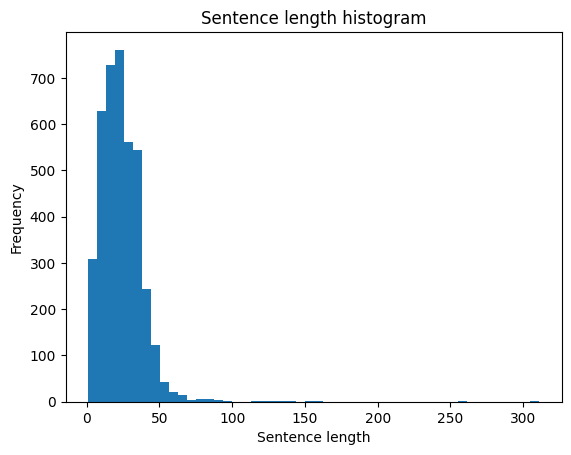

In [11]:
plot_sentence_length_histogram(irish_tagger.X_train)

In [12]:
# max_sentence_num_words = 100
irish_tagger.preprocess_data(max_sentence_num_words=100, with_punctuation=True)
print(f"Sentence 1: {irish_tagger.X_train[0]}")
print(f"Label 1: {irish_tagger.y_train[0]}")

Sentence 1: As lár na tubaiste is ea stadfaidh an ghrian sula rachaidh sí a luí san áigéan thiar ó lonrú anuas ; solas ní bheidh ar fáil ach oiread na hoíche nó mar éiclips lán .
Label 1: [ 2  8  6  8  4 11 16  6  8 14 16 11 10  8  2  8  3  2  8  3 13  8 10 16
  2  8 14  8  6  8  5  2  8  1 13  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


We are going to use a vocabulary size of 10,000 words, as the vocabulary size of the Irish UD treebank is 14,119 words.


In [14]:
X_plain_train = {token for sentence in irish_tagger.X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in irish_tagger.X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

Number of unique tokens: 14119
Number of unique tokens: 3184


## Model training

First, we are going to train a model with the following hyperparameter configuration:

- LSTM units: 64
- Embedding size: 50
- Batch size: 64
- Bidirectional LSTM: True

In this case, we start adding a bidirectional layer to the initial model, because we saw that it works well in English and Galician.


In [27]:
# irish_tagger.build_model(vocabulary_size=10000, units=64, output_dim=50, bidirectional=True)
# irish_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

irish_tagger.load_model("initial_model", model_folder="./models/irish")
irish_tagger.show_training_log()

Model loaded from ./models/irish\initial_model.keras
Epoch 1/16 - Loss: 2.4258, Accuracy: 0.2885, Val Loss: 2.2229, Val Accuracy: 0.3064
Epoch 2/16 - Loss: 1.7836, Accuracy: 0.4881, Val Loss: 1.3292, Val Accuracy: 0.6622
Epoch 3/16 - Loss: 0.8393, Accuracy: 0.7761, Val Loss: 0.6919, Val Accuracy: 0.8153
Epoch 4/16 - Loss: 0.4216, Accuracy: 0.8957, Val Loss: 0.4516, Val Accuracy: 0.8787
Epoch 5/16 - Loss: 0.2523, Accuracy: 0.9380, Val Loss: 0.3640, Val Accuracy: 0.8955
Epoch 6/16 - Loss: 0.1797, Accuracy: 0.9542, Val Loss: 0.3249, Val Accuracy: 0.9016
Epoch 7/16 - Loss: 0.1414, Accuracy: 0.9625, Val Loss: 0.3032, Val Accuracy: 0.9094
Epoch 8/16 - Loss: 0.1180, Accuracy: 0.9684, Val Loss: 0.2944, Val Accuracy: 0.9094
Epoch 9/16 - Loss: 0.1021, Accuracy: 0.9718, Val Loss: 0.2853, Val Accuracy: 0.9105
Epoch 10/16 - Loss: 0.0895, Accuracy: 0.9755, Val Loss: 0.2812, Val Accuracy: 0.9126
Epoch 11/16 - Loss: 0.0790, Accuracy: 0.9786, Val Loss: 0.2807, Val Accuracy: 0.9109
Epoch 12/16 - Loss: 0

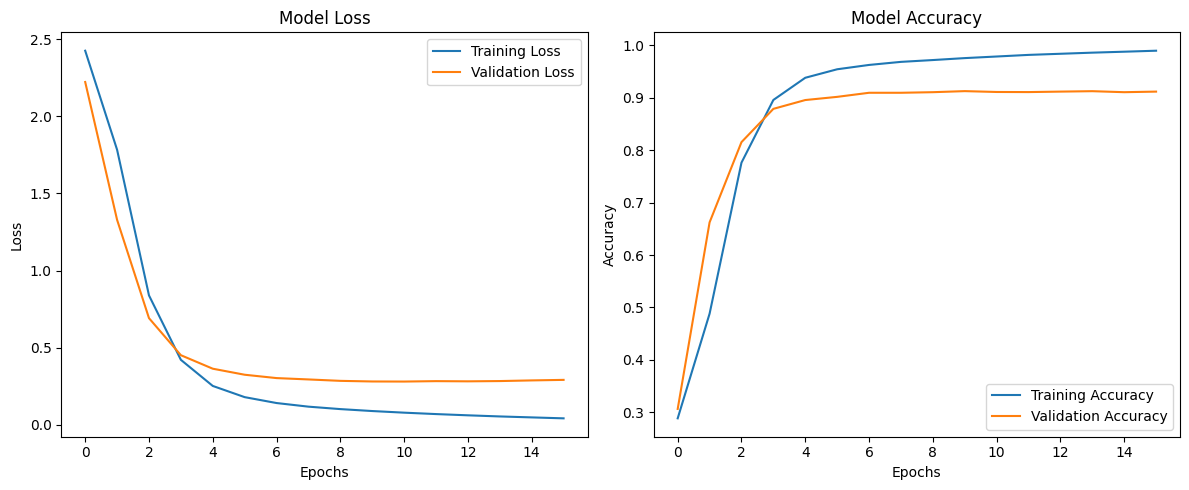

In [25]:
irish_tagger.plot_training_history()

In [26]:
irish_tagger.evaluate()
irish_tagger.save_model(model_folder="./models/irish", model_filename="initial_model")

15/15 [==============================] - 1s 49ms/step - loss: 0.2856 - accuracy: 0.9091
Model saved in ./models/irish\initial_model.keras
Training history saved in ./models/irish\initial_model_training_history.json


15/15 [==============================] - 2s 16ms/step


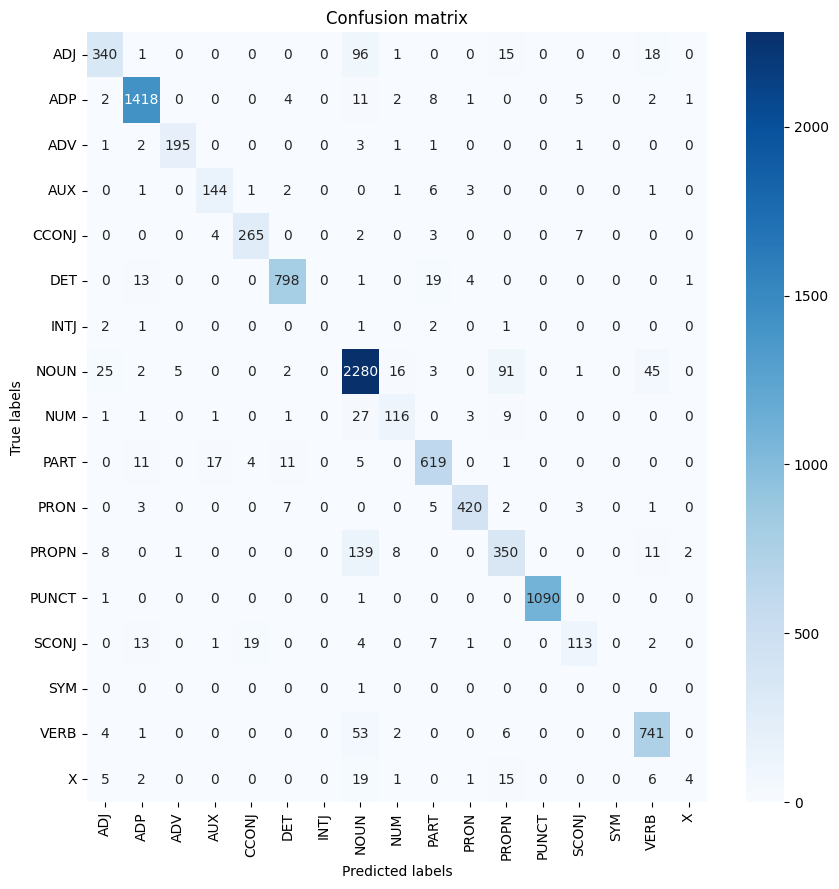

In [28]:
irish_tagger.plot_confusion_matrix()

Now, we are going to perform a little hyperparameter tuning. We are going to tune each hyperparameter separately. The hyperparameters we are going to tune are:

- LSTM units: 16, 32, 64, 128

We saw that the embedding size does not have a significant impact on the accuracy on the test set with Galician, so we are going to keep it fixed at 50. Also, we saw that the batch size does not have a significant impact on the accuracy on the test set with English, so we are going to keep it fixed at 64.


### LTSM units


In [37]:
# irish_tagger.build_model(vocabulary_size=10000, units=16, output_dim=50, bidirectional=True)
# irish_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

irish_tagger.load_model("units16", model_folder="./models/irish")
irish_tagger.show_training_log()

Model loaded from ./models/irish\units16.keras
Epoch 1/26 - Loss: 2.5813, Accuracy: 0.2794, Val Loss: 2.3022, Val Accuracy: 0.2636
Epoch 2/26 - Loss: 2.0806, Accuracy: 0.3468, Val Loss: 1.9794, Val Accuracy: 0.4223
Epoch 3/26 - Loss: 1.5760, Accuracy: 0.5899, Val Loss: 1.3350, Val Accuracy: 0.6886
Epoch 4/26 - Loss: 0.9775, Accuracy: 0.7729, Val Loss: 0.8958, Val Accuracy: 0.7819
Epoch 5/26 - Loss: 0.6376, Accuracy: 0.8482, Val Loss: 0.6723, Val Accuracy: 0.8270
Epoch 6/26 - Loss: 0.4440, Accuracy: 0.8990, Val Loss: 0.5387, Val Accuracy: 0.8702
Epoch 7/26 - Loss: 0.3234, Accuracy: 0.9354, Val Loss: 0.4590, Val Accuracy: 0.8862
Epoch 8/26 - Loss: 0.2532, Accuracy: 0.9480, Val Loss: 0.4136, Val Accuracy: 0.8923
Epoch 9/26 - Loss: 0.2111, Accuracy: 0.9535, Val Loss: 0.3866, Val Accuracy: 0.8967
Epoch 10/26 - Loss: 0.1840, Accuracy: 0.9572, Val Loss: 0.3680, Val Accuracy: 0.8981
Epoch 11/26 - Loss: 0.1636, Accuracy: 0.9608, Val Loss: 0.3542, Val Accuracy: 0.9008
Epoch 12/26 - Loss: 0.1482,

In [30]:
irish_tagger.evaluate()
irish_tagger.save_model(model_folder="./models/irish", model_filename="units16")

15/15 [==============================] - 0s 27ms/step - loss: 0.3116 - accuracy: 0.9084
Model saved in ./models/irish\units16.keras
Training history saved in ./models/irish\units16_training_history.json


In [36]:
# irish_tagger.build_model(vocabulary_size=10000, units=32, output_dim=50, bidirectional=True)
# irish_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

irish_tagger.load_model("units32", model_folder="./models/irish")
irish_tagger.show_training_log()

Model loaded from ./models/irish\units32.keras
Epoch 1/19 - Loss: 2.4874, Accuracy: 0.2918, Val Loss: 2.2726, Val Accuracy: 0.2947
Epoch 2/19 - Loss: 1.9873, Accuracy: 0.3869, Val Loss: 1.7635, Val Accuracy: 0.5188
Epoch 3/19 - Loss: 1.2580, Accuracy: 0.6861, Val Loss: 0.9952, Val Accuracy: 0.7555
Epoch 4/19 - Loss: 0.6579, Accuracy: 0.8423, Val Loss: 0.6124, Val Accuracy: 0.8501
Epoch 5/19 - Loss: 0.3854, Accuracy: 0.9173, Val Loss: 0.4537, Val Accuracy: 0.8837
Epoch 6/19 - Loss: 0.2633, Accuracy: 0.9418, Val Loss: 0.3875, Val Accuracy: 0.8936
Epoch 7/19 - Loss: 0.2038, Accuracy: 0.9505, Val Loss: 0.3490, Val Accuracy: 0.8996
Epoch 8/19 - Loss: 0.1685, Accuracy: 0.9569, Val Loss: 0.3266, Val Accuracy: 0.9023
Epoch 9/19 - Loss: 0.1451, Accuracy: 0.9615, Val Loss: 0.3122, Val Accuracy: 0.9063
Epoch 10/19 - Loss: 0.1279, Accuracy: 0.9658, Val Loss: 0.3026, Val Accuracy: 0.9083
Epoch 11/19 - Loss: 0.1139, Accuracy: 0.9697, Val Loss: 0.2969, Val Accuracy: 0.9102
Epoch 12/19 - Loss: 0.1028,

In [32]:
irish_tagger.evaluate()
irish_tagger.save_model(model_folder="./models/irish", model_filename="units32")

15/15 [==============================] - 0s 25ms/step - loss: 0.2976 - accuracy: 0.9080
Model saved in ./models/irish\units32.keras
Training history saved in ./models/irish\units32_training_history.json


In [35]:
# irish_tagger.build_model(vocabulary_size=10000, units=128, output_dim=50, bidirectional=True)
# irish_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

irish_tagger.load_model("units128", model_folder="./models/irish")
irish_tagger.show_training_log()

Model loaded from ./models/irish\units128.keras
Epoch 1/14 - Loss: 2.3462, Accuracy: 0.3033, Val Loss: 2.1791, Val Accuracy: 0.3103
Epoch 2/14 - Loss: 1.5796, Accuracy: 0.5501, Val Loss: 1.0145, Val Accuracy: 0.7150
Epoch 3/14 - Loss: 0.6231, Accuracy: 0.8265, Val Loss: 0.5283, Val Accuracy: 0.8453
Epoch 4/14 - Loss: 0.3097, Accuracy: 0.9183, Val Loss: 0.3814, Val Accuracy: 0.8886
Epoch 5/14 - Loss: 0.1984, Accuracy: 0.9485, Val Loss: 0.3280, Val Accuracy: 0.9034
Epoch 6/14 - Loss: 0.1493, Accuracy: 0.9601, Val Loss: 0.3090, Val Accuracy: 0.9073
Epoch 7/14 - Loss: 0.1215, Accuracy: 0.9668, Val Loss: 0.2989, Val Accuracy: 0.9105
Epoch 8/14 - Loss: 0.1025, Accuracy: 0.9714, Val Loss: 0.2916, Val Accuracy: 0.9117
Epoch 9/14 - Loss: 0.0885, Accuracy: 0.9747, Val Loss: 0.2899, Val Accuracy: 0.9141
Epoch 10/14 - Loss: 0.0767, Accuracy: 0.9786, Val Loss: 0.2915, Val Accuracy: 0.9120
Epoch 11/14 - Loss: 0.0671, Accuracy: 0.9815, Val Loss: 0.2908, Val Accuracy: 0.9121
Epoch 12/14 - Loss: 0.0580

In [34]:
irish_tagger.evaluate()
irish_tagger.save_model(model_folder="./models/irish", model_filename="units128")

15/15 [==============================] - 1s 45ms/step - loss: 0.2979 - accuracy: 0.9086
Model saved in ./models/irish\units128.keras
Training history saved in ./models/irish\units128_training_history.json


The results on the test set of the different models are summarized in the following table:

| **LSTM units** | **Acccuracy** |  **Loss**  |
| :------------: | :-----------: | :--------: |
|       16       |    0.9084     |   0.3116   |
|       32       |    0.9080     |   0.2976   |
|       64       |  **0.9091**   | **0.2856** |
|      128       |    0.9086     |   0.2979   |


### Best model

Analyzing the results, we observe once again that the accuracy difference between models on the test set is minimal. The model with 64 LSTM units achieved the highest accuracy, so we will select it as the best model.

Regarding the confusion matrix, we can draw similar conclusions to those observed with the Galician dataset: the 'PROPN' tag yields the poorest results, frequently being confused with the 'NOUN' tag, which is the most common tag in the dataset. This frequent misclassification likely occurs because nouns are abundant in sentences, while proper nouns are comparatively rare, making it harder for the model to learn the distinctions between them. Additionally, these tags often appear in similar contexts, further complicating differentiation.

Parameters of the best model (initial_model):

- `Vocabulary size`: 10,000
- `Embedding size`: 50
- `LSTM units`: 64
- `Bidirectional`: True
- `Batch size`: 64


Model loaded from ./models/irish\initial_model.keras
15/15 [==============================] - 2s 26ms/step


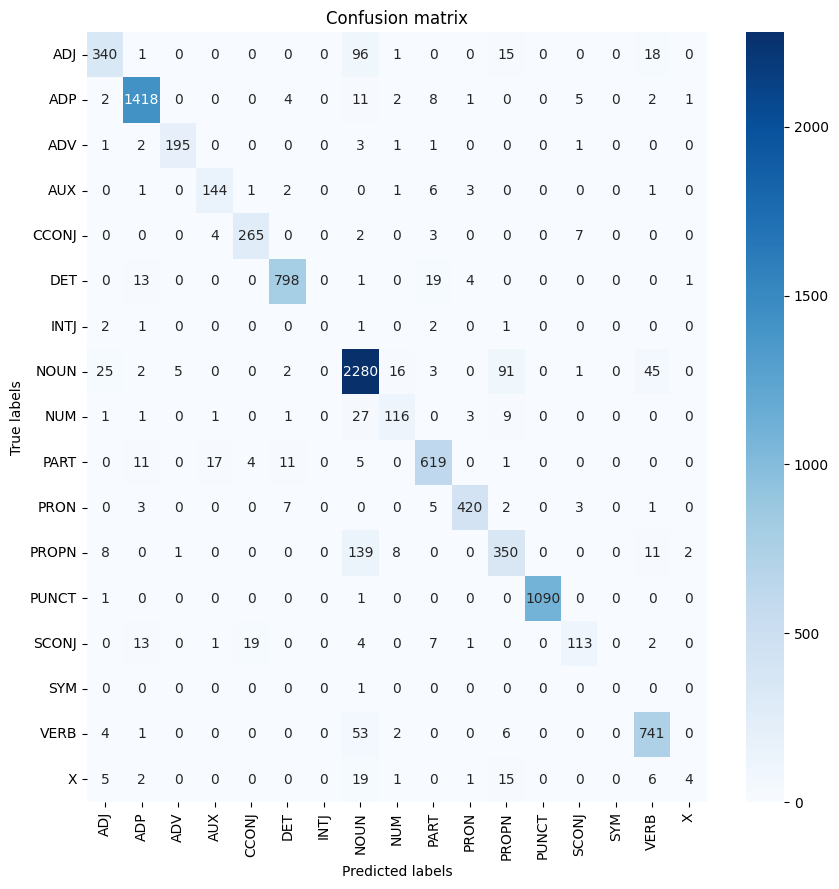

In [39]:
irish_tagger.load_model("initial_model", model_folder="./models/irish")
irish_tagger.evaluate()
irish_tagger.plot_confusion_matrix()